In [1]:
# DATA CLEANING 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(df.info())
print(df.head())
print(f"Number of empty strings in TotalCharges: {df[df['TotalCharges'] == ' '].shape[0]}")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("\nData after cleaning:")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15880\348491101.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


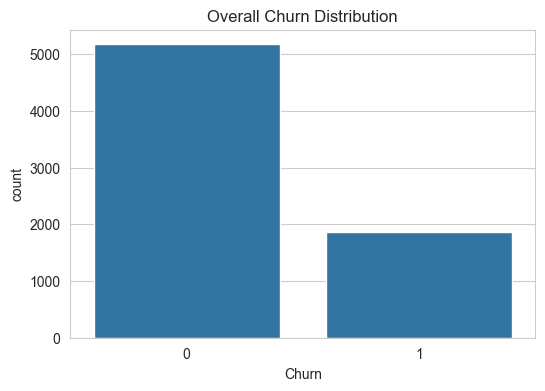

Churn Rate:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


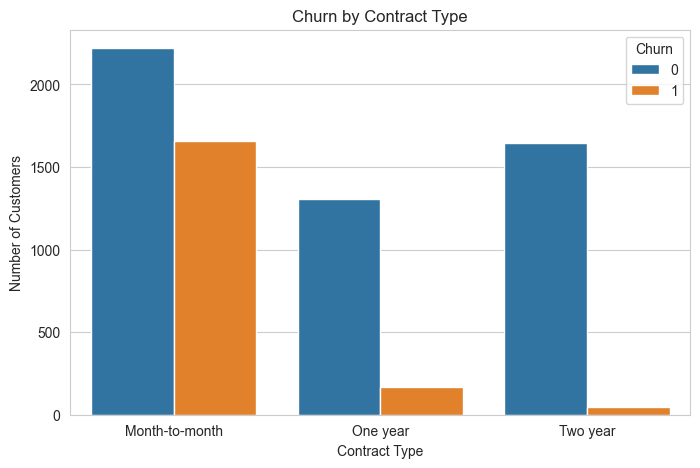

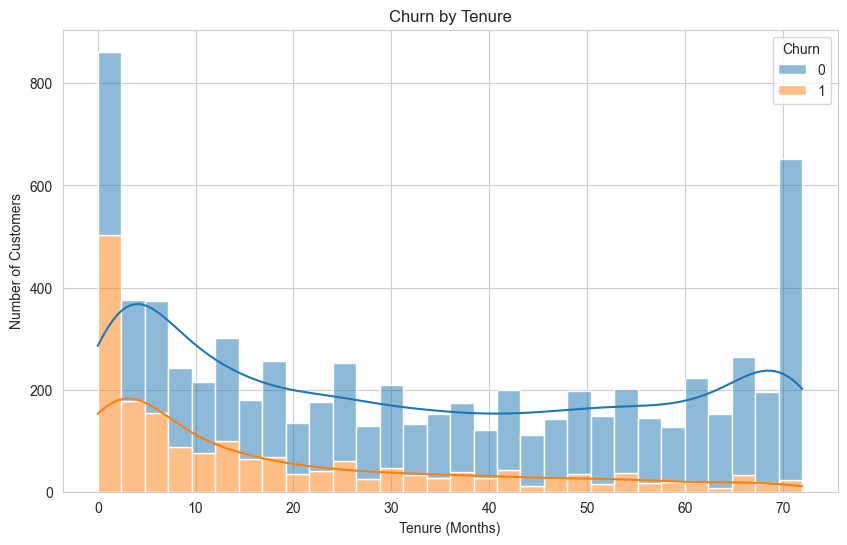

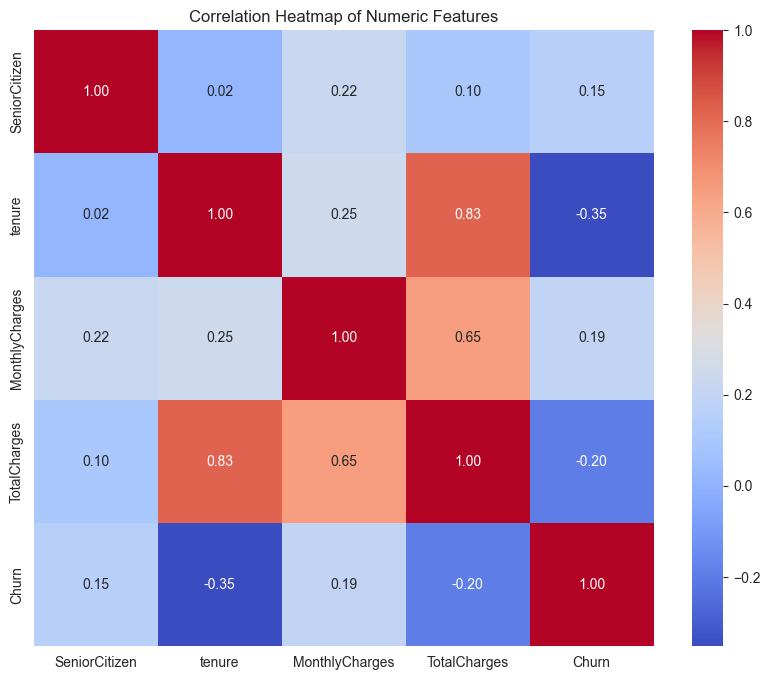

In [2]:
# VISUALIZE CHURN ACROSS CATEGORIES 
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Overall Churn Distribution')
plt.show()
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(f"Churn Rate:\n{churn_rate}")
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, kde=True)
plt.title('Churn by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()
numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_processed = df.drop('customerID', axis=1)

categorical_features = df_processed.select_dtypes(include=['object']).columns
numerical_features = df_processed.select_dtypes(include=np.number).columns.drop('Churn')

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print("Preprocessor created successfully.")

Preprocessor created successfully.


In [4]:
# DEFINE MODELS 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))

final_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])
final_model_pipeline.fit(X_train, y_train)

--- Logistic Regression ---
Accuracy: 0.8055
ROC-AUC: 0.8420
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

--- Random Forest ---
Accuracy: 0.7857
ROC-AUC: 0.8246
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

--- XGBoost ---
Accuracy: 0.7850
ROC-AUC: 0.8214
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy     

e:\Project\Churn prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:31:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Project\Churn prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:31:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


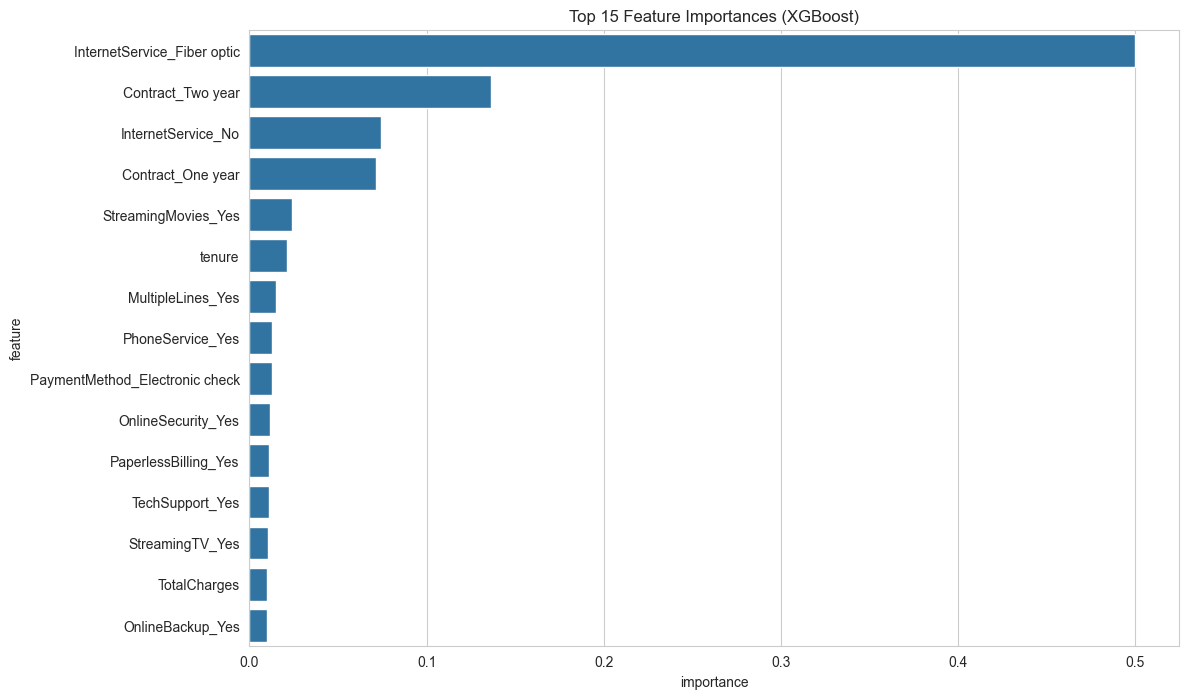

In [ ]:
# FEATURE IMPORTANCE 
ohe_feature_names = final_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])
importances = final_model_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()

In [ ]:
import joblib

joblib.dump(final_model_pipeline, 'saved_model/churn_model_pipeline.joblib')
print("Model pipeline saved successfully to saved_model/churn_model_pipeline.joblib")

Model pipeline saved successfully to saved_model/churn_model_pipeline.joblib
